In [14]:
# 30 May 2022

In [15]:
from importlib import reload

In [16]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import cv2

In [17]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import open_gym_buoy_with_wind as oceangym

In [19]:
import open_gym_buoy_with_wind as oceangym

In [20]:
reload(oceangym)

<module 'open_gym_buoy_with_wind' from '/home/nrw/projects/oceansim/open_gym_buoy_with_wind.py'>

self.canvas_size=array([300, 600]) self.grid_width=50 self.wind_grid_shape=array([ 6, 12])
oops ran out of battery, final return -10
final position (184, 30)


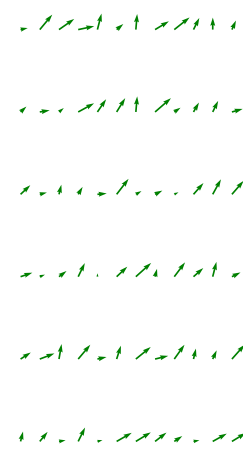

In [21]:
env = oceangym.OceanScape()
obs = env.reset()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()
    #plt.show()

    if done == True:
        cv2.waitKey(0)
        break

env.close()

# TODO: add wind affect on batt
#       + create wind region, reset wind region, 
#       + add effect on battery, and 
# TODO: plot wind region

In [22]:
plt.ion()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
from stable_baselines3 import A2C

In [25]:
env = oceangym.OceanScape()

self.canvas_size=array([300, 600]) self.grid_width=50 self.wind_grid_shape=array([ 6, 12])


In [26]:
from tqdm.auto import tqdm

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


test progress bar:  32%|███▏      | 322/1000 [00:09<00:21, 30.94it/s]

oops ran out of battery, final return -10
final position (32, 30)


test progress bar:  72%|███████▏  | 718/1000 [00:20<00:09, 30.20it/s]

oops ran out of battery, final return -10
final position (30, 30)


test progress bar: 100%|██████████| 1000/1000 [00:27<00:00, 36.19it/s]


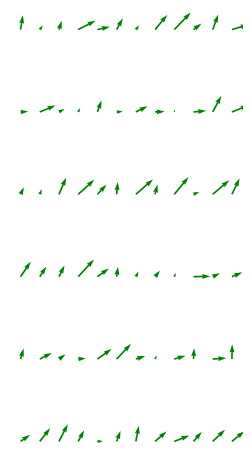

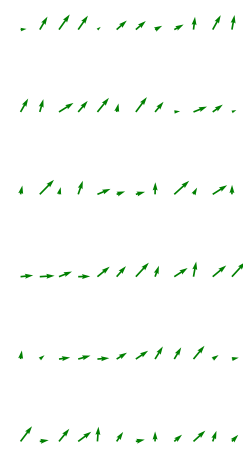

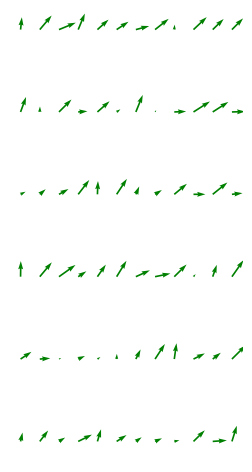

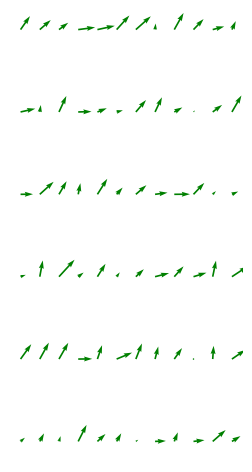

In [28]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1)

obs = env.reset()
for i in tqdm(range(1000), desc='test progress bar'):
  action, _state = model.predict(obs, deterministic=True)
  obs, reward, done, info = env.step(action)
  env.render()
  if done:
    obs = env.reset()